# Torchvision Keypoint R-CNN

This is a Person Keypoint R-CNN colab notebook using [torchvision 0.3.0](https://pytorch.org/docs/stable/torchvision/index.html).

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install torchvision 0.3.0

In [0]:
import os
from os.path import exists, join, basename, splitext

# install torchvision for CPU, see: https://github.com/pytorch/vision/issues/946
!pip install -q -U https://download.pytorch.org/whl/cpu/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)
  
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

## Initialize Person Keypoint R-CNN and download pretrained weights

In [0]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model = model.eval()

## Visualization function

We are going to use the visualization method from the [facebookresearch/maskrcnn-benchmark](https://github.com/facebookresearch/maskrcnn-benchmark):

In [0]:
if not exists('keypoint.py'):
  !wget https://raw.githubusercontent.com/facebookresearch/maskrcnn-benchmark/e0a525a0139baf7086117b7ed3fd318a4878d71c/maskrcnn_benchmark/structures/keypoint.py
    
from keypoint import PersonKeypoints
def vis_keypoints(img, kps, kp_thresh=2, alpha=0.7):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    dataset_keypoints = PersonKeypoints.NAMES
    kp_lines = PersonKeypoints.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)

    # Draw mid shoulder / mid hip first for better visualization.
    mid_shoulder = (
        kps[:2, dataset_keypoints.index('right_shoulder')] +
        kps[:2, dataset_keypoints.index('left_shoulder')]) / 2.0
    sc_mid_shoulder = np.minimum(
        kps[2, dataset_keypoints.index('right_shoulder')],
        kps[2, dataset_keypoints.index('left_shoulder')])
    mid_hip = (
        kps[:2, dataset_keypoints.index('right_hip')] +
        kps[:2, dataset_keypoints.index('left_hip')]) / 2.0
    sc_mid_hip = np.minimum(
        kps[2, dataset_keypoints.index('right_hip')],
        kps[2, dataset_keypoints.index('left_hip')])
    nose_idx = dataset_keypoints.index('nose')
    if sc_mid_shoulder > kp_thresh and kps[2, nose_idx] > kp_thresh:
        cv2.line(
            kp_mask, tuple(mid_shoulder), tuple(kps[:2, nose_idx]),
            color=colors[len(kp_lines)], thickness=2, lineType=cv2.LINE_AA)
    if sc_mid_shoulder > kp_thresh and sc_mid_hip > kp_thresh:
        cv2.line(
            kp_mask, tuple(mid_shoulder), tuple(mid_hip),
            color=colors[len(kp_lines) + 1], thickness=2, lineType=cv2.LINE_AA)

    # Draw the keypoints.
    for l in range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
            cv2.line(
                kp_mask, p1, p2,
                color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        if kps[2, i2] > kp_thresh:
            cv2.circle(
                kp_mask, p2,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)
  
  
def overlay_keypoints(image, kps, scores):
  kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
  for region in kps:
    image = vis_keypoints(image, region.transpose((1, 0)))
  return image

--2019-05-28 13:55:17--  https://raw.githubusercontent.com/facebookresearch/maskrcnn-benchmark/e0a525a0139baf7086117b7ed3fd318a4878d71c/maskrcnn_benchmark/structures/keypoint.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6555 (6.4K) [text/plain]
Saving to: ‘keypoint.py’

keypoint.py         100%[===================>]   6.40K  --.-KB/s    in 0s      

2019-05-28 13:55:17 (97.1 MB/s) - ‘keypoint.py’ saved [6555/6555]



## Segment objects on a test image

First, dowload a test image from internet:

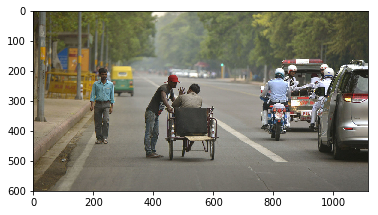

In [0]:
IMAGE_URL = 'https://raw.githubusercontent.com/facebookresearch/DensePose/master/DensePoseData/demo_data/demo_im.jpg'


image_file = basename(IMAGE_URL)
!wget -q -O {image_file} {IMAGE_URL}
plt.imshow(matplotlib.image.imread(image_file))

Execute  Keypoint R-CNN model on that image and show the result:

In [0]:
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image)
output = model([image_tensor])[0]
print('executed in %.3fs' % (time.time() - t))

executed in 13.141s


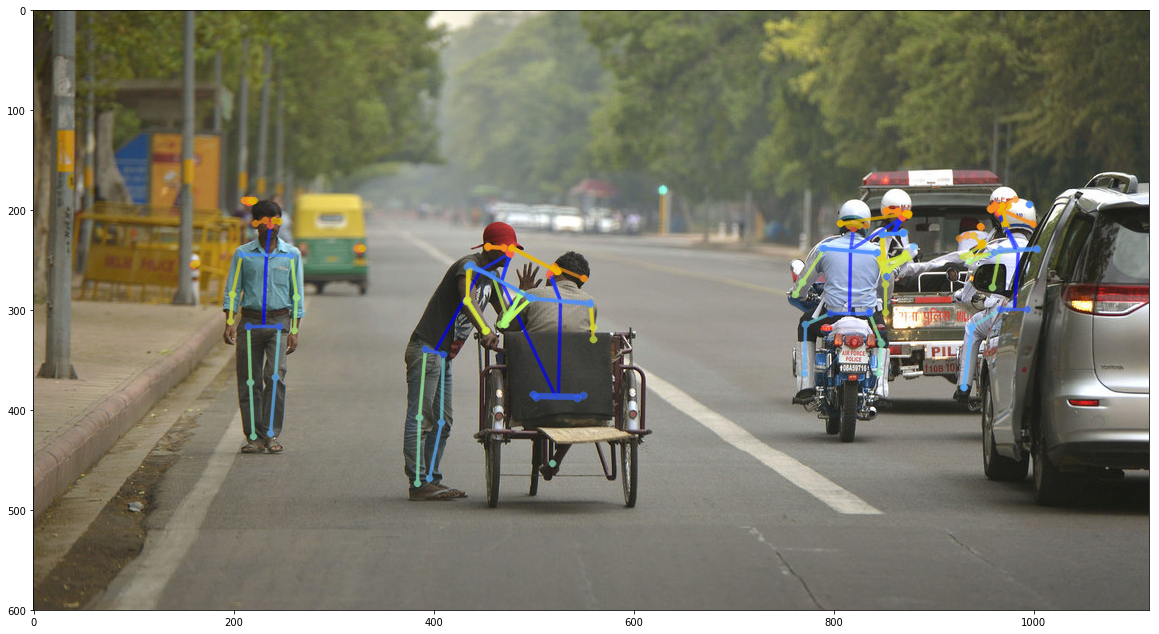

In [0]:
result_image = np.array(image.copy())
result_image = overlay_keypoints(result_image, output['keypoints'], output['keypoints_scores'])

plt.figure(figsize=(20, 15))
plt.imshow(result_image)